# Summer Institute 221.629.79

### Assignment 2: Application exercise

**Student:** Zanga Ali Mohamed TRAORE (zangatraore14@gmail.com)

##### Import the needed packages

### Assingment

Here we provide the tweets collected about the TRIPS waiver tweeted by civil society organizations. Please use NMF topic modeling to summarize topics in the tweets.
1. Report the number of topics and coherence of the model.
  - Please try out the different numbers of topics and features. Then compare the model coherence and report on the most coherent model.
  - Write one or two sentences reflecting on what you did to find the best model.
1. Report the top 10 keywords of each topic.
  - In the code, we provide the code to create a table of topics (model results). Please report this table.
1. Summarize the most interesting topic you find in the data and provide some insights in terms of the topic.

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
# from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
# from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#  import data here
df = pd.read_csv("/content/drive/MyDrive/221.629.79 Summer Institute 2023 NLP module/TRIPS waiver CSO.csv")
df.head()

,date,name,text
0,7/7/20,PHM,Kate Elder MSFaccess COVAX the only proposal ...
1,10/4/20,PHM,India and South Africa move wto to waive off T...
2,11/16/20,PHM,Pls read this excellent commentary by Prasanna...
3,2/2/21,PHM,Countries need to stop blocking proposal for T...
4,2/2/21,PHM,dont block access to COVID19 tools Support t...


In [ ]:
# check how many rows are in the dataset
df.shape

(2619, 3)

In [ ]:
# Check how many rows have missing values for text column
df.text.isnull().values.sum()

0

In [ ]:
# Exclude all rows with null text
df.dropna(inplace=True)
# Print the number of records we have in the dataset after we drop all the nan values
df.shape

(2619, 3)

In [ ]:
# keep useful columns in the dataset
df_trips = df[['text','name']]
# Get the word count for each document
df_trips['word_count'] = df['text'].apply(lambda x: len(str(x).split(" ")))
df_trips.head()

,text,name,word_count
0,Kate Elder MSFaccess COVAX the only proposal ...,PHM,27
1,India and South Africa move wto to waive off T...,PHM,35
2,Pls read this excellent commentary by Prasanna...,PHM,44
3,Countries need to stop blocking proposal for T...,PHM,15
4,dont block access to COVID19 tools Support t...,PHM,13


In [ ]:
# Summary statistics
df_trips.word_count.describe()

count    2619.000000
mean       35.938908
std         8.600510
min         5.000000
25%        31.000000
50%        38.000000
75%        42.000000
max        66.000000
Name: word_count, dtype: float64

In [ ]:
# just to get a sizable data to work with in this module
df1= df_trips[(df_trips['word_count']>=35)&(df_trips['word_count']<=42)]

In [ ]:
df1.shape

(1193, 3)

In [ ]:
df1.head()

,text,name,word_count
1,India and South Africa move wto to waive off T...,PHM,35
5,CSOs from the GlobalSouth urge not block t...,PHM,40
9,No one is safe unless everyone is safe We urge...,PHM,39
14,Dear JustinTrudeau while will vaccinate eve...,PHM,42
24,9 out of 10 in lowincome countries will have t...,PHM,42


##Data Cleaning

In the following section, we will see how we should clean the data for topic modeling.

In [ ]:
# Removing unwanted characters
import re
df1['text'] = df1['text'].str.replace('X', '')
df1['text'] = df1['text'].str.replace('{', '')
df1['text'] = df1['text'].str.replace('}', '')
df1['text'] = df1['text'].str.replace('/', '')
df1.head()

,text,name,word_count
1,India and South Africa move wto to waive off T...,PHM,35
5,CSOs from the GlobalSouth urge not block t...,PHM,40
9,No one is safe unless everyone is safe We urge...,PHM,39
14,Dear JustinTrudeau while will vaccinate eve...,PHM,42
24,9 out of 10 in lowincome countries will have t...,PHM,42


In [ ]:
# Top 20 most frequent words
freq = pd.Series(' '.join(df1['text']).split()).value_counts()[:20]
freq

the            2221
to             1758
of              932
TRIPSWaiver     870
and             703
a               669
in              547
is              545
for             521
on              423
COVID19         378
WTO             336
The             327
vaccines        307
countries       302
pandemic        300
are             291
that            286
now             274
amp             267
dtype: int64

In [ ]:
# Work with only nouns. Use NLTK to get only nouns in the corpus
def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)]
    return ' '.join(all_nouns)

In [ ]:
import nltk
nltk.download('punkt')
df1['data_nouns'] = pd.DataFrame(df1.text.apply(nouns))
df1.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,text,name,word_count,data_nouns
1,India and South Africa move wto to waive off T...,PHM,35,India South Africa move wto TRIPS protection t...
5,CSOs from the GlobalSouth urge not block t...,PHM,40,CSOs GlobalSouth urge TRIPSwaiver proposal wto...
9,No one is safe unless everyone is safe We urge...,PHM,39,one everyone TRIPSwaiver proposal wto country ...
14,Dear JustinTrudeau while will vaccinate eve...,PHM,42,Dear JustinTrudeau Canadian September frontlin...
24,9 out of 10 in lowincome countries will have t...,PHM,42,countries countries populations times Civil So...


In [ ]:
# Further cleaning, removing stopwords, lemmatizing
import re
temp =[]
my_stop_words = text.ENGLISH_STOP_WORDS

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

for sentence in df1['data_nouns']:
    sentence = sentence.lower() # Lowercase Text
    cleaner = re.compile('<.*?>')
    sentence = re.sub(cleaner, ' ', sentence)  # Remove html tags
    sentence = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    sentence = re.sub(r'[.|,|)|(|\|/]',r' ',sentence) # removing puntuations

    words = [lemmatizer.lemmatize(word) for word in sentence.split() if word not in my_stop_words] # removing stopwords and lemm
    temp.append(words)

final_X = temp

In [ ]:
final_X[:2]

[['india',
  'south',
  'africa',
  'wto',
  'trip',
  'protection',
  'track',
  'covid19',
  'care',
  'patent',
  'copyright',
  'design',
  'data',
  'protection',
  'right',
  'covid19',
  'innovation',
  'g2h2geneva',
  'filesgeneva',
  'vivasaludbe',
  'nothilfe'],
 ['csos',
  'globalsouth',
  'urge',
  'tripswaiver',
  'proposal',
  'wto',
  'access',
  'covid19',
  'med',
  'diagnostics',
  'nocovidmonopolies',
  'read',
  'letter',
  'scottmorrisonmp',
  'australiaungva',
  'dfat',
  'phaa',
  'baumfran',
  'davidglegge']]

In [ ]:
# connect words into sentences
sent = []
for row in final_X:
    sequ = ''
    for word in row:
        sequ = sequ + ' ' + word
    sent.append(sequ)
final_X = sent

In [ ]:
final_X[:2]

[' india south africa wto trip protection track covid19 care patent copyright design data protection right covid19 innovation g2h2geneva filesgeneva vivasaludbe nothilfe',
 ' csos globalsouth urge tripswaiver proposal wto access covid19 med diagnostics nocovidmonopolies read letter scottmorrisonmp australiaungva dfat phaa baumfran davidglegge']

In [ ]:
df1['cleaned'] = final_X
df1.head()

,text,name,word_count,data_nouns,cleaned
1,India and South Africa move wto to waive off T...,PHM,35,India South Africa move wto TRIPS protection t...,india south africa wto trip protection track ...
5,CSOs from the GlobalSouth urge not block t...,PHM,40,CSOs GlobalSouth urge TRIPSwaiver proposal wto...,csos globalsouth urge tripswaiver proposal wt...
9,No one is safe unless everyone is safe We urge...,PHM,39,one everyone TRIPSwaiver proposal wto country ...,tripswaiver proposal wto country access covid...
14,Dear JustinTrudeau while will vaccinate eve...,PHM,42,Dear JustinTrudeau Canadian September frontlin...,dear justintrudeau canadian september frontli...
24,9 out of 10 in lowincome countries will have t...,PHM,42,countries countries populations times Civil So...,country country population time civil society...


# Model Building
In the following section, we will build the model for topic modeling.


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import NMF
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
# from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
# from nltk.stem import PorterStemmer
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
pd.set_option('max_colwidth', 1000)
pd.options.display.max_rows = 500
df1.head()

,text,name,word_count,data_nouns,cleaned
1,India and South Africa move wto to waive off TRIPS protection to fast track COVID19 care Move if approved may suspend patent copyright design data protection rights on COVID19 related innovations\n\n \n\nG2H2Geneva FilesGeneva vivasaludbe nothilfe,PHM,35,India South Africa move wto TRIPS protection track COVID19 care Move patent copyright design data protection rights COVID19 innovations G2H2Geneva FilesGeneva vivasaludbe nothilfe,india south africa wto trip protection track covid19 care patent copyright design data protection right covid19 innovation g2h2geneva filesgeneva vivasaludbe nothilfe
5,CSOs from the GlobalSouth urge not block the temporary TRIPSwaiver proposal wto to ensure greater access to COVID19 meds amp diagnostics NoCovidMonopolies \n\nRead our letter \n\nScottMorrisonMP AustraliaUNGVA dfat PHAA baumfran DavidGLegge,PHM,40,CSOs GlobalSouth urge TRIPSwaiver proposal wto access COVID19 meds diagnostics NoCovidMonopolies Read letter ScottMorrisonMP AustraliaUNGVA dfat PHAA baumfran DavidGLegge,csos globalsouth urge tripswaiver proposal wto access covid19 med diagnostics nocovidmonopolies read letter scottmorrisonmp australiaungva dfat phaa baumfran davidglegge
9,No one is safe unless everyone is safe We urge not to block the temporary TRIPSwaiver proposal wto and ensure every country has access to COVID19 meds and diagnostics \nNoCovidMonopolies \n\nernasolberg dagiulstein IselinNybo,PHM,39,one everyone TRIPSwaiver proposal wto country access COVID19 meds diagnostics NoCovidMonopolies dagiulstein IselinNybo,tripswaiver proposal wto country access covid19 med diagnostics nocovidmonopolies dagiulstein iselinnybo
14,Dear JustinTrudeau while will vaccinate every Canadian by September 2021 frontline workers in the developing await their first shot We urge you not to block TRIPSwaiver and ensure better access\n\nRead the letter here \n\nNoCovidMonopolies,PHM,42,Dear JustinTrudeau Canadian September frontline workers shot TRIPSwaiver access letter NoCovidMonopolies,dear justintrudeau canadian september frontline worker shot tripswaiver access letter nocovidmonopolies
24,9 out of 10 in lowincome countries will have to wait until 2022 or later to be vaccinated while rich countries have secured enough to vaccinate their populations three times over\nCivil Society from global north calls for supporting TRIPSwaiver\n,PHM,42,countries countries populations times Civil Society north TRIPSwaiver,country country population time civil society north tripswaiver


In [ ]:
# let us see the top 20 again after cleaning
freq_NN = pd.Series(' '.join(df1['cleaned']).split()).value_counts()[:20]
freq_NN

tripswaiver          1024
vaccine               511
covid19               418
wto                   395
country               324
world                 194
pharma                177
press                 165
access                160
treatment             152
waiver                150
biden                 145
people                143
production            140
nocovidmonopolies     128
pandemic              104
ip                    102
big                   101
health                 97
eu                     95
dtype: int64

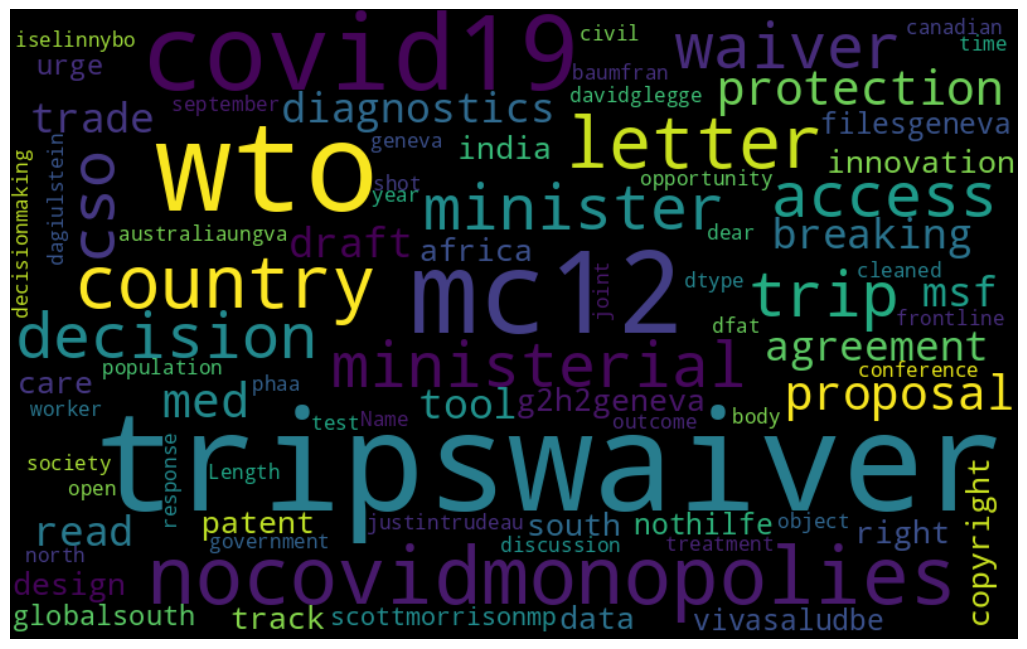

In [ ]:
#Wordcloud

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(df1['cleaned']))
plt.figure(1,figsize=(13, 10))
fig=plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
#Use CountVectorizer to get bigrams to visualize
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(df1['cleaned'])

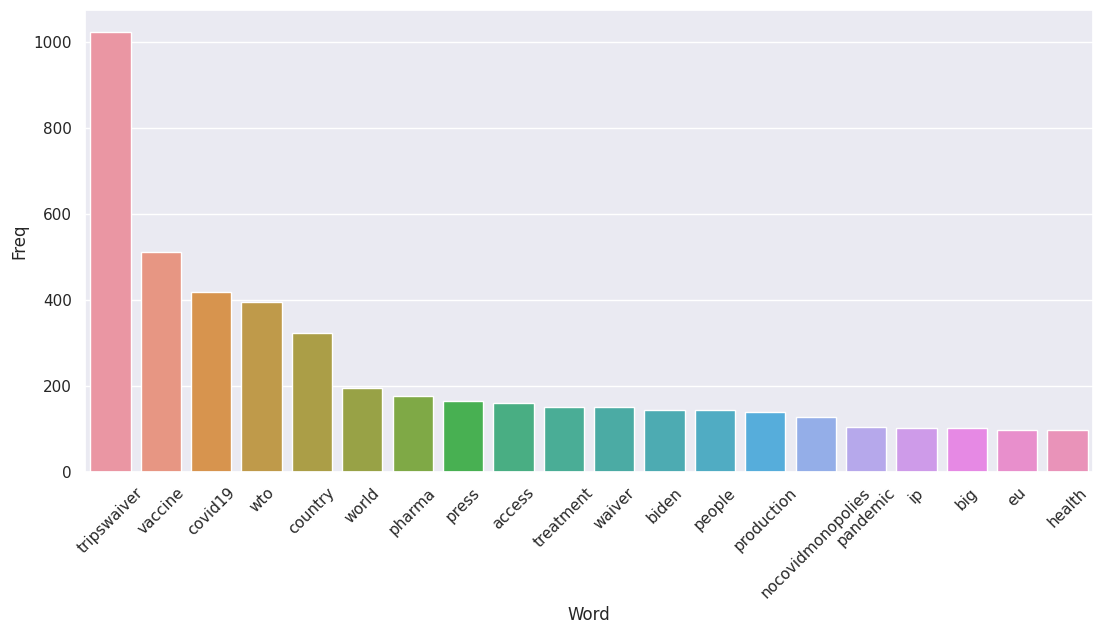

In [ ]:
# Most frequently occuring words
def get_top_n_words(corpus,n=None):
    vec = CountVectorizer().fit(df1['cleaned'])
    bag_of_words=vec.transform(df1['cleaned'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top_words = get_top_n_words(df1['cleaned'], n=20)
top_df = pd.DataFrame(top_words)
top_df.columns = ['Word', 'Freq']

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
g = sns.barplot(x='Word', y='Freq', data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=45)
fig = g.get_figure()

              Bi-gram  Freq
0     wto tripswaiver   120
1          big pharma    93
2      access covid19    67
3       covid19 tools    63
4    press conference    59
5    covid19 vaccines    56
6       tech transfer    54
7    tripswaiver tech    51
8         covid19 wto    51
9          wto waiver    51
10          friday et    50
11             et sen    50
12        sen sanders    50
13  sanders lawmakers    50
14   lawmakers groups    50
15   groups petitions    50
16     petitions push    50
17         push biden    50
18     biden blockage    50
19   blockage covid19    50


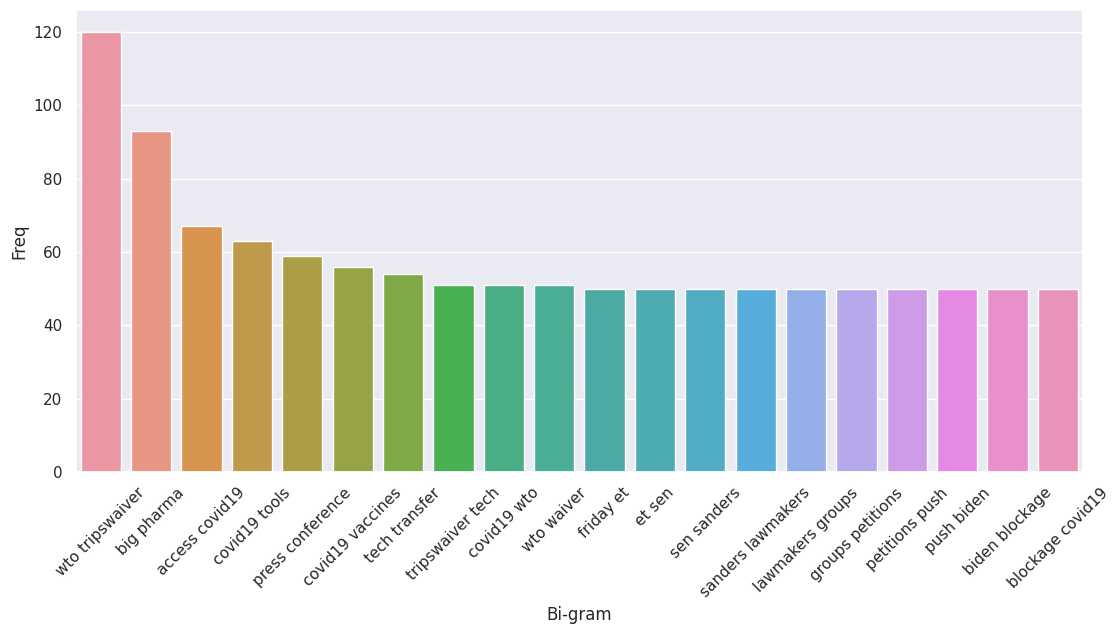

In [ ]:
# Most frequently Co-occuring words
def get_top_n2_words(corpus,n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),max_features=2000).fit(df1['data_nouns'])
    bag_of_words=vec1.transform(df1['data_nouns'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word , idx in vec1.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
# Convert most freq words to datafame for visuals

top2_words = get_top_n2_words(df1['data_nouns'], n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns = ['Bi-gram', 'Freq']

# for bigram wordcloud
top100_words = get_top_n2_words(df1['data_nouns'], n=100)
top100_df = pd.DataFrame(top100_words)
top100_df.columns = ['Bi-gram', 'Freq']
print(top2_df)

# barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,6)})
h = sns.barplot(x='Bi-gram', y='Freq', data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
fig = h.get_figure()

In [ ]:
top100_df.head()

,Bi-gram,Freq
0,wto tripswaiver,120
1,big pharma,93
2,access covid19,67
3,covid19 tools,63
4,press conference,59


In [ ]:
top100_df['Bi_gram'] = top100_df['Bi-gram'].str.replace(' ','_')
top100_df.head()

,Bi-gram,Freq,Bi_gram
0,wto tripswaiver,120,wto_tripswaiver
1,big pharma,93,big_pharma
2,access covid19,67,access_covid19
3,covid19 tools,63,covid19_tools
4,press conference,59,press_conference


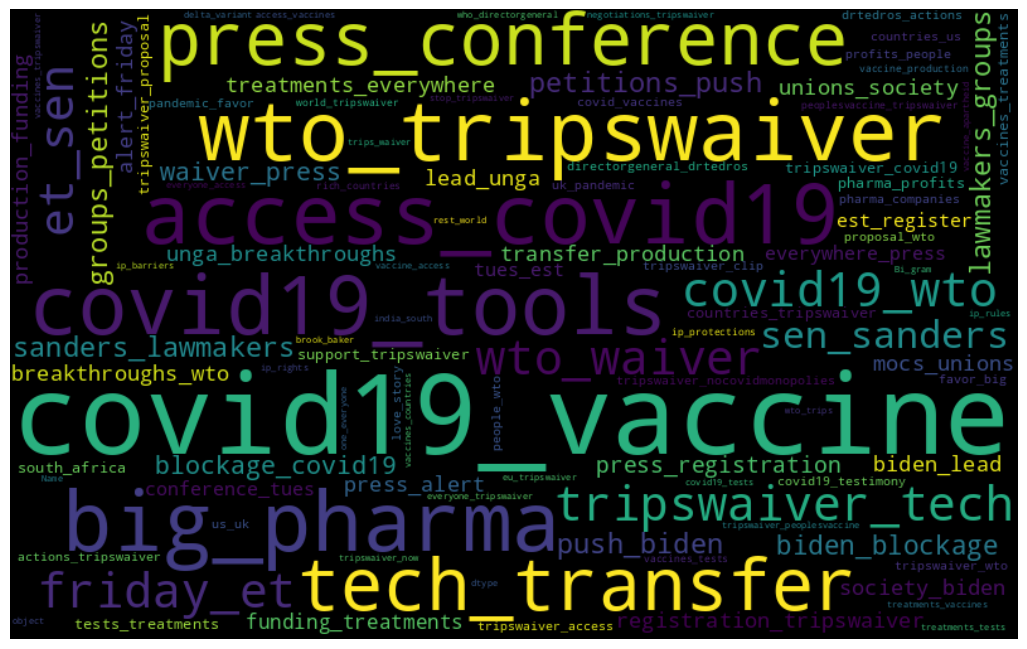

In [ ]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(str(top100_df['Bi_gram']))
plt.figure(1,figsize=(13, 10))
fig=plt.figure(1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Term vectorization term weighting:

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=10000, ngram_range=(1,1),
                                  analyzer='word')
tfidf = tfidf_vectorizer.fit_transform(df1['cleaned'])
# get the feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [ ]:
print('Vocabulary has %d distinct terms' % len(tfidf_feature_names))

Vocabulary has 1095 distinct terms


In [ ]:
# The terms with the highest TF-IDF scores across all documents in the document-term matrix.
import operator
def rank_terms( tfidf, tfidf_feature_names ):
    # get the sums over each column
    sums = tfidf.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(tfidf_feature_names):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
ranking = rank_terms(tfidf, tfidf_feature_names)
for i, pair in enumerate( ranking[0:10] ):
    print( "%02d. %s (%.0f)" % ( i+1, pair[0], pair[1] ) )

01. tripswaiver (78)
02. vaccine (69)
03. covid19 (56)
04. country (55)
05. wto (53)
06. world (38)
07. pharma (34)
08. access (32)
09. press (32)
10. treatment (30)


# NMF Model Fitting.

1. Report the number of topics and coherence of the model.
  - Please try out the different numbers of topics and features. Then compare the model coherence and report on the most coherent model.
  - Write one or two sentences reflecting on what you did to find the best model.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from sklearn.datasets import fetch_20newsgroups
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import TfidfModel
import gensim

In [ ]:
def display_topics(model, feature_names, no_top_words):
    col1 = 'topic'
    col2 = 'top_ten_words'
    dct = {col1: [], col2: []}
    for topic_idx, topic in enumerate(model.components_):
        dct[col1].append(str(topic_idx))
        dct[col2].append(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
    return pd.DataFrame.from_dict(dct)

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Cover a sentence to a list of words for coherence calculation
data = df1['cleaned'].values.tolist()
data_words = list(sent_to_words(data))

1. Report the top 10 keywords of each topic.
  - In the code, we provide the code to create a table of topics (model results). Please report this table.

In [ ]:
n_topics = 10 # number of topics in the document
n_features = 6000 # number of features used for model fitting


data = df1['cleaned']

tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=10000, ngram_range=(1,1), analyzer='word')
tfidf = tfidf_vectorizer.fit_transform(data)

# Fit the NMF model
nmf = NMF(
    n_components=n_topics,
    max_iter=2000,
    random_state=2000,
    init="nndsvda",
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.8,
).fit(tfidf)

dictionary = Dictionary(data_words)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens
test_corpus = [
    dictionary.doc2bow(document)
    for document
    in data_words
]

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
no_top_words = 10
topic_word = display_topics(nmf, tfidf_feature_names, 20)
topic_word

,topic,top_ten_words
0,0,press sen sander lawmaker registration blockage friday push alert et group petition biden waiver wto covid19 tripswaiver anaswanson jamespoliti loriannlarocco
1,1,country tripswaiver peoplesvaccine population negotiation technology people dos booster crisis health production income nocovidmonopolies monopoly whats manufacturer supply waiver msf
2,2,mocs est breakthrough unga tues lead union funding register society transfer conference tech production press biden treatment wto tripswaiver morningmoneyben
3,3,big profit pharma testimony favor uk pandemic people rich wto flyingwithsara covid19 tripswaiver repblumenauer country life rosadelauro repschakowsky day paul
4,4,directorgeneral love clip drtedros story action repblumenauer tripswaiver repschakowsky paul farmer pih brook baker healthgap oxfamamerica abbymaxman hrw akshayasays srsimone
5,5,vaccine variant treatment test tripswaiver production access covid delta virus covid19 apartheid property omicron therapeutic manufacturing supply way end nation
6,6,ip protection company pharma development right medicine life patent government claim price covid19 investment med wto big peoplesvaccine monopoly treatment
7,7,world dos time tripswaiver rest way potus people pandemic germany leader year covid booster population vaccination billion day peoplesvaccine health
8,8,wto south mc12 africa india amp trip nocovidmonopolies tripswaiver month ministerial waiver read proposal letter trade covid19 council conference csos
9,9,tool covid19 access eu nocovidmonopolies proposal dear time eucommission tripswaiver government support eucouncil barrier thing manufacturer effort ask negotiation counterproposal


In [ ]:
dictionary = Dictionary(data_words)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens
tfidf_ = TfidfModel(dictionary=dictionary)
corpus = [
    dictionary.doc2bow(document)
    for document
    in data_words
]
corpus_tfidf = list(tfidf_[corpus])
nmf.id2word = dictionary
nmf.get_topics = lambda: nmf.components_
nmf.show_topics = lambda top_n: get_sklearn_topics(model, top_n)
coherence = CoherenceModel(
    model=nmf,
    corpus=corpus_tfidf,
    coherence='u_mass'
    ).get_coherence()
print('Coherence of the model is:', round(coherence,2))

Coherence of the model is: -7.8


**We will change the number of topic to 5 to ensure coherence of the model.**

In [ ]:
n_topics = 5 # number of topics in the document
n_features = 6000 # number of features used for model fitting


data = df1['cleaned']

tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words= 'english', max_features=10000, ngram_range=(1,1), analyzer='word')
tfidf = tfidf_vectorizer.fit_transform(data)

# Fit the NMF model
nmf = NMF(
    n_components=n_topics,
    max_iter=2000,
    random_state=2000,
    init="nndsvda",
    beta_loss="frobenius",
    alpha_W=0.00005,
    alpha_H=0.00005,
    l1_ratio=0.8,
).fit(tfidf)

dictionary = Dictionary(data_words)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens
test_corpus = [
    dictionary.doc2bow(document)
    for document
    in data_words
]

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
no_top_words = 10
topic_word = display_topics(nmf, tfidf_feature_names, 20)
topic_word

,topic,top_ten_words
0,0,press sander sen lawmaker registration friday blockage push alert et group petition biden waiver wto covid19 tripswaiver anaswanson jamespoliti loriannlarocco
1,1,vaccine country tripswaiver covid19 access world tool nocovidmonopolies wto treatment peoplesvaccine eu test ip time government proposal variant support production
2,2,breakthrough est mocs tues unga lead union funding conference society register transfer tech production press biden treatment wto tripswaiver mc12
3,3,big pharma profit testimony favor uk pandemic people rich country wto flyingwithsara covid19 tripswaiver repblumenauer life rosadelauro repschakowsky choice day
4,4,directorgeneral love clip drtedros story action repblumenauer tripswaiver repschakowsky paul farmer pih brook baker healthgap oxfamamerica abbymaxman akshayasays hrw srsimone


In [ ]:
dictionary = Dictionary(data_words)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=20000)  # filter out too in/frequent tokens
tfidf_ = TfidfModel(dictionary=dictionary)
corpus = [
    dictionary.doc2bow(document)
    for document
    in data_words
]
corpus_tfidf = list(tfidf_[corpus])
nmf.id2word = dictionary
nmf.get_topics = lambda: nmf.components_
nmf.show_topics = lambda top_n: get_sklearn_topics(model, top_n)
coherence = CoherenceModel(
    model=nmf,
    corpus=corpus_tfidf,
    coherence='u_mass'
    ).get_coherence()
print('Coherence of the model is:', round(coherence,2))

Coherence of the model is: -8.29


**The best model is the one with the highest coherence. In our case, this is the model with 10 subjects. Coherence is equal to - 7.49**


1. Summarize the most interesting topic you find in the data and provide some insights in terms of the topic.

In [ ]:
nmf_features = nmf.transform(tfidf)
pd.DataFrame(nmf_features).idxmax(axis=1).value_counts()
predict = pd.DataFrame(nmf_features).idxmax(axis=1).values
domin = pd.DataFrame()
domin['topic'] = predict
domin['text'] = df1['text'].values

In [ ]:
## Topic 1: 5 Samples
domin.loc[domin['topic'] == 1]['text'][:10]

0                          India and South Africa move wto to waive off TRIPS protection to fast track COVID19 care Move if approved may suspend patent copyright design data protection rights on COVID19 related innovations\n\n \n\nG2H2Geneva FilesGeneva vivasaludbe nothilfe
1                        CSOs from the GlobalSouth urge     not block the temporary TRIPSwaiver proposal wto to ensure greater access to COVID19 meds amp diagnostics NoCovidMonopolies \n\nRead our letter    \n\nScottMorrisonMP AustraliaUNGVA dfat PHAA baumfran DavidGLegge  
2                                          No one is safe unless everyone is safe We urge     not to block the temporary TRIPSwaiver proposal wto and ensure every country has access to COVID19 meds and diagnostics \nNoCovidMonopolies \n\nernasolberg dagiulstein IselinNybo  
3                          Dear JustinTrudeau while    will vaccinate every Canadian by September 2021 frontline workers in the developing   await their first shot We urge you